DRIVER AUDIO ACTIVITY ANALYSIS SYSTEM

✓ Output directory: C:\Users\akhilesh zende\Downloads\DriverAudioAnalysis_20260209_085502

STEP 1: GENERATE SYNTHETIC DRIVER AUDIO

🎵 Generating synthetic driver audio...
   ⏱️  0.0s - 3.0s: silence
   ⏱️  3.0s - 8.0s: ambient_noise
   ⏱️  8.0s - 12.0s: speaking
   ⏱️  12.0s - 14.0s: yawning
   ⏱️  14.0s - 22.0s: music
   ⏱️  22.0s - 25.0s: ambient_noise
   ⏱️  25.0s - 25.5s: horn
   ⏱️  25.5s - 28.0s: ambient_noise
   ⏱️  28.0s - 33.0s: speaking
   ⏱️  33.0s - 37.0s: heavy_breathing
   ⏱️  37.0s - 39.0s: yawning
   ⏱️  39.0s - 45.0s: music
   ⏱️  45.0s - 50.0s: speaking
   ⏱️  50.0s - 53.0s: ambient_noise
   ⏱️  53.0s - 55.0s: yawning
   ⏱️  55.0s - 60.0s: silence

✓ Generated 60.00 seconds of audio

💾 Audio saved: C:\Users\akhilesh zende\Downloads\DriverAudioAnalysis_20260209_085502\driver_audio_simulation.wav

STEP 2: ANALYZE AUDIO

📊 Analyzing audio...
   ⏳ Processed 0/119 windows
   ⏳ Processed 20/119 windows
   ⏳ Processed 40/119 windows
   

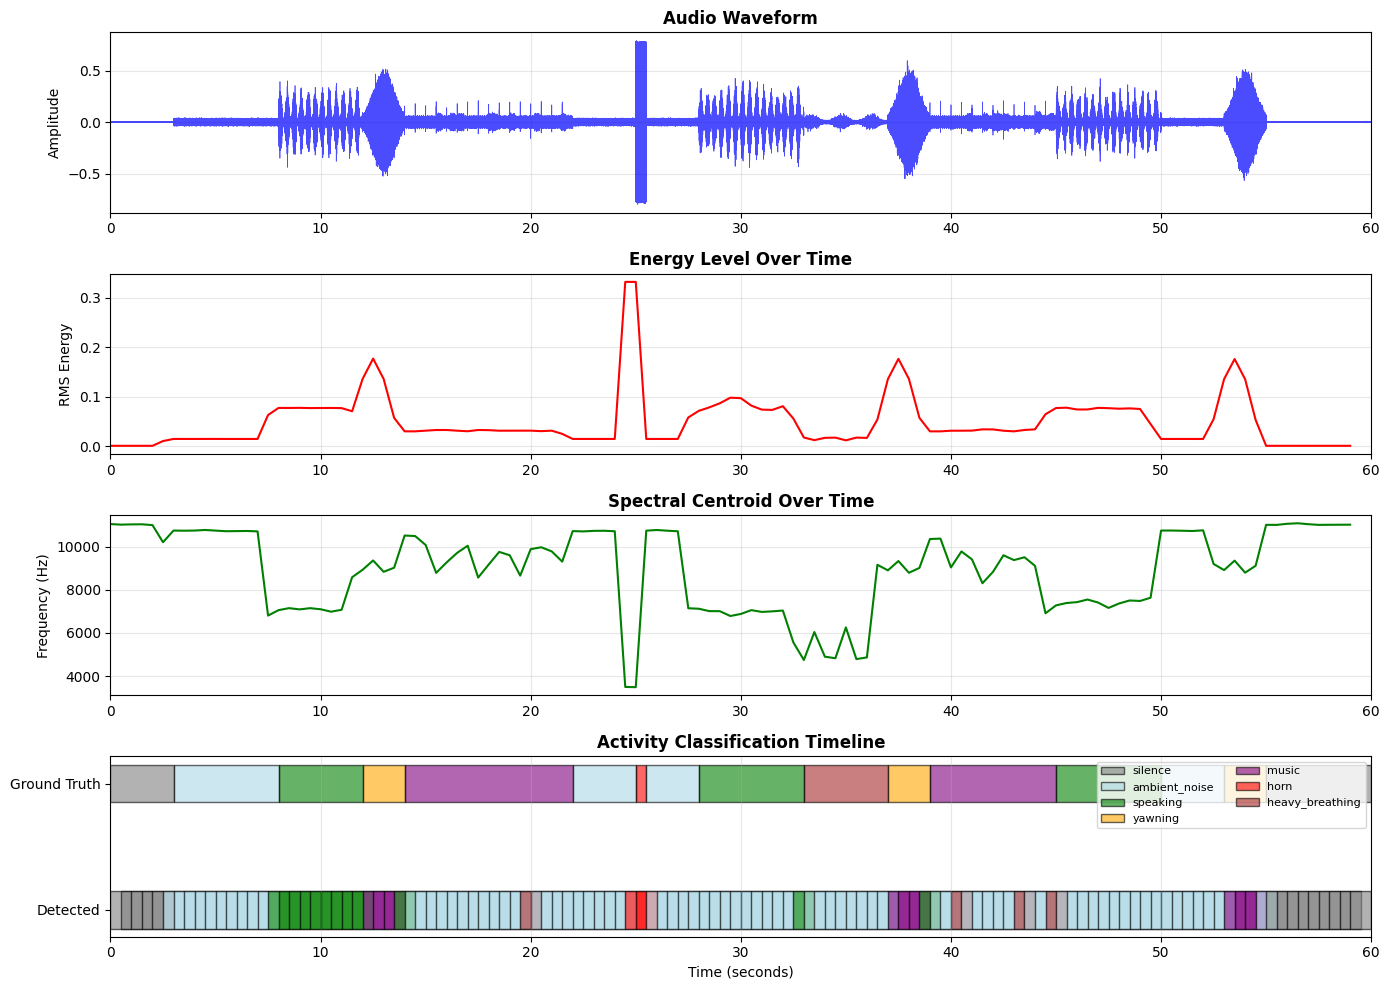

In [2]:
#!/usr/bin/env python3
"""
QUESTION 4: DRIVER AUDIO ACTIVITY ANALYSIS
==========================================

This script:
1. Generates synthetic driver audio with different activities
2. Analyzes audio to detect driver states
3. Classifies audio segments into categories

Audio Classes Detected:
- Silence (no sound)
- Normal driving (low ambient noise)
- Speaking (driver talking)
- Yawning (fatigue indicator)
- Music/Radio
- Horn/Alert sounds
- Heavy breathing (stress/fatigue)
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import wavfile
from scipy import signal
import os
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("DRIVER AUDIO ACTIVITY ANALYSIS SYSTEM")
print("=" * 80)

# ============================================================================
# CONFIGURATION
# ============================================================================

OUTPUT_FOLDER_NAME = "DriverAudioAnalysis_" + datetime.now().strftime("%Y%m%d_%H%M%S")
DOWNLOADS_PATH = str(Path.home() / "Downloads")
OUTPUT_DIR = os.path.join(DOWNLOADS_PATH, OUTPUT_FOLDER_NAME)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"\n✓ Output directory: {OUTPUT_DIR}")

# Audio parameters
SAMPLE_RATE = 44100  # Hz
DURATION = 60  # seconds (1 minute test audio)

# Output paths
AUDIO_OUTPUT = os.path.join(OUTPUT_DIR, "driver_audio_simulation.wav")
CSV_OUTPUT = os.path.join(OUTPUT_DIR, "audio_activity_analysis.csv")
PLOT_OUTPUT = os.path.join(OUTPUT_DIR, "audio_analysis_plot.png")
SUMMARY_OUTPUT = os.path.join(OUTPUT_DIR, "audio_summary.txt")

# ============================================================================
# PART 1: SYNTHETIC AUDIO GENERATION
# ============================================================================

class DriverAudioGenerator:
    """Generate realistic driver audio with different activity phases"""
    
    def __init__(self, sample_rate=44100):
        self.sr = sample_rate
        self.audio_segments = []
        self.labels = []
        
    def generate_silence(self, duration):
        """Generate silence with minimal ambient noise"""
        samples = int(duration * self.sr)
        # Very low amplitude white noise for realism
        audio = np.random.normal(0, 0.001, samples)
        return audio
    
    def generate_ambient_noise(self, duration, intensity=0.02):
        """Generate low-frequency ambient car noise"""
        samples = int(duration * self.sr)
        t = np.linspace(0, duration, samples)
        
        # Low frequency rumble (engine, road noise)
        noise = intensity * np.sin(2 * np.pi * 80 * t)  # 80 Hz engine
        noise += intensity * 0.5 * np.sin(2 * np.pi * 120 * t)  # Harmonic
        
        # Add white noise
        noise += np.random.normal(0, intensity * 0.3, samples)
        
        return noise
    
    def generate_speech(self, duration):
        """Simulate speech patterns"""
        samples = int(duration * self.sr)
        t = np.linspace(0, duration, samples)
        
        # Speech has frequency components between 85-255 Hz (fundamental)
        # and harmonics up to 3-4 kHz
        speech = np.zeros(samples)
        
        # Fundamental frequency varies (pitch variation)
        for i in range(5):
            freq = np.random.uniform(100, 250)
            phase = np.random.uniform(0, 2 * np.pi)
            amp = np.random.uniform(0.1, 0.3)
            speech += amp * np.sin(2 * np.pi * freq * t + phase)
        
        # Add harmonics
        for i in range(3):
            freq = np.random.uniform(500, 3000)
            phase = np.random.uniform(0, 2 * np.pi)
            amp = np.random.uniform(0.05, 0.15)
            speech += amp * np.sin(2 * np.pi * freq * t + phase)
        
        # Add amplitude modulation (speech envelope)
        envelope = 0.5 * (1 + np.sin(2 * np.pi * 3 * t))  # 3 Hz modulation
        speech = speech * envelope
        
        # Add noise
        speech += np.random.normal(0, 0.02, samples)
        
        return speech * 0.4  # Scale to reasonable level
    
    def generate_yawn(self, duration=2.0):
        """Simulate yawning sound"""
        samples = int(duration * self.sr)
        t = np.linspace(0, duration, samples)
        
        # Yawn starts low, goes high, then back down
        freq_start = 200
        freq_peak = 500
        freq_end = 150
        
        # Create frequency sweep
        freq = np.zeros(samples)
        mid = samples // 2
        
        # Rising part
        freq[:mid] = np.linspace(freq_start, freq_peak, mid)
        # Falling part
        freq[mid:] = np.linspace(freq_peak, freq_end, samples - mid)
        
        # Generate sound
        phase = 2 * np.pi * np.cumsum(freq) / self.sr
        yawn = 0.3 * np.sin(phase)
        
        # Add envelope (gradual increase then decrease)
        envelope = np.exp(-((t - duration/2) ** 2) / (duration/4))
        yawn = yawn * envelope
        
        # Add breath noise
        yawn += np.random.normal(0, 0.1, samples) * envelope
        
        return yawn
    
    def generate_music(self, duration):
        """Simulate background music/radio"""
        samples = int(duration * self.sr)
        t = np.linspace(0, duration, samples)
        
        # Simple chord progression
        music = np.zeros(samples)
        
        # Bass line
        bass_freqs = [110, 130, 98, 146]  # A, C, G, D
        for i, freq in enumerate(bass_freqs):
            start = i * samples // 4
            end = (i + 1) * samples // 4
            t_seg = t[start:end]
            music[start:end] += 0.15 * np.sin(2 * np.pi * freq * t_seg)
        
        # Melody (higher frequencies)
        for i in range(8):
            freq = np.random.choice([440, 494, 523, 587, 659])  # A, B, C, D, E
            start = np.random.randint(0, samples - self.sr // 4)
            end = start + self.sr // 4
            if end < samples:
                t_seg = np.arange(end - start) / self.sr
                music[start:end] += 0.1 * np.sin(2 * np.pi * freq * t_seg)
        
        # Add rhythm (percussion-like)
        for i in range(0, samples, self.sr // 2):
            if i + 100 < samples:
                music[i:i+100] += 0.2 * np.random.randn(100)
        
        return music * 0.3  # Lower volume for background
    
    def generate_horn(self, duration=0.5):
        """Simulate car horn"""
        samples = int(duration * self.sr)
        t = np.linspace(0, duration, samples)
        
        # Horn is typically 400-500 Hz
        horn = 0.7 * np.sin(2 * np.pi * 450 * t)
        horn += 0.3 * np.sin(2 * np.pi * 900 * t)  # Harmonic
        
        return horn
    
    def generate_heavy_breathing(self, duration):
        """Simulate heavy/stressed breathing"""
        samples = int(duration * self.sr)
        t = np.linspace(0, duration, samples)
        
        # Breathing cycle is about 0.5-1 Hz (30-60 breaths/min)
        breath_freq = 0.7  # Hz
        
        # Breathing sound (filtered noise)
        noise = np.random.normal(0, 1, samples)
        
        # Create breathing envelope
        envelope = 0.3 * (1 + np.sin(2 * np.pi * breath_freq * t))
        
        # Apply envelope
        breathing = noise * envelope
        
        # Low-pass filter to simulate air flow
        sos = signal.butter(4, 1000, 'low', fs=self.sr, output='sos')
        breathing = signal.sosfilt(sos, breathing)
        
        return breathing * 0.2
    
    def create_driver_scenario(self):
        """Create a realistic driving scenario with different phases"""
        
        print("\n🎵 Generating synthetic driver audio...")
        
        scenarios = [
            # (duration, activity, generator_func)
            (3, "silence", lambda: self.generate_silence(3)),
            (5, "ambient_noise", lambda: self.generate_ambient_noise(5, 0.02)),
            (4, "speaking", lambda: self.generate_speech(4) + self.generate_ambient_noise(4, 0.01)),
            (2, "yawning", lambda: self.generate_yawn(2) + self.generate_ambient_noise(2, 0.01)),
            (8, "music", lambda: self.generate_music(8) + self.generate_ambient_noise(8, 0.015)),
            (3, "ambient_noise", lambda: self.generate_ambient_noise(3, 0.02)),
            (0.5, "horn", lambda: self.generate_horn(0.5) + self.generate_ambient_noise(0.5, 0.02)),
            (2.5, "ambient_noise", lambda: self.generate_ambient_noise(2.5, 0.02)),
            (5, "speaking", lambda: self.generate_speech(5) + self.generate_ambient_noise(5, 0.01)),
            (4, "heavy_breathing", lambda: self.generate_heavy_breathing(4) + self.generate_ambient_noise(4, 0.01)),
            (2, "yawning", lambda: self.generate_yawn(2) + self.generate_ambient_noise(2, 0.01)),
            (6, "music", lambda: self.generate_music(6) + self.generate_ambient_noise(6, 0.015)),
            (5, "speaking", lambda: self.generate_speech(5) + self.generate_ambient_noise(5, 0.01)),
            (3, "ambient_noise", lambda: self.generate_ambient_noise(3, 0.02)),
            (2, "yawning", lambda: self.generate_yawn(2) + self.generate_ambient_noise(2, 0.01)),
            (5, "silence", lambda: self.generate_silence(5)),
        ]
        
        audio_segments = []
        timeline = []
        current_time = 0
        
        for duration, activity, generator in scenarios:
            print(f"   ⏱️  {current_time:.1f}s - {current_time + duration:.1f}s: {activity}")
            
            audio = generator()
            audio_segments.append(audio)
            
            timeline.append({
                'start_time': current_time,
                'end_time': current_time + duration,
                'duration': duration,
                'activity': activity
            })
            
            current_time += duration
        
        # Concatenate all segments
        full_audio = np.concatenate(audio_segments)
        
        # Normalize
        max_val = np.max(np.abs(full_audio))
        if max_val > 0:
            full_audio = full_audio / max_val * 0.8  # Leave some headroom
        
        # Convert to 16-bit PCM
        audio_int16 = np.int16(full_audio * 32767)
        
        print(f"\n✓ Generated {len(full_audio)/self.sr:.2f} seconds of audio")
        
        return audio_int16, pd.DataFrame(timeline)

# ============================================================================
# PART 2: AUDIO ANALYSIS
# ============================================================================

class DriverAudioAnalyzer:
    """Analyze audio for driver activity detection"""
    
    def __init__(self, sample_rate=44100):
        self.sr = sample_rate
    
    def extract_features(self, audio_segment):
        """Extract audio features from a segment"""
        
        # RMS Energy
        rms = np.sqrt(np.mean(audio_segment ** 2))
        
        # Zero Crossing Rate
        zcr = np.mean(np.abs(np.diff(np.sign(audio_segment)))) / 2
        
        # Spectral features
        fft = np.fft.fft(audio_segment)
        magnitude = np.abs(fft[:len(fft)//2])
        freqs = np.fft.fftfreq(len(audio_segment), 1/self.sr)[:len(fft)//2]
        
        # Spectral Centroid
        if np.sum(magnitude) > 0:
            spectral_centroid = np.sum(freqs * magnitude) / np.sum(magnitude)
        else:
            spectral_centroid = 0
        
        # Spectral Rolloff (85% of energy)
        cumsum = np.cumsum(magnitude)
        if cumsum[-1] > 0:
            rolloff_idx = np.where(cumsum >= 0.85 * cumsum[-1])[0]
            spectral_rolloff = freqs[rolloff_idx[0]] if len(rolloff_idx) > 0 else 0
        else:
            spectral_rolloff = 0
        
        # Peak Frequency
        peak_idx = np.argmax(magnitude)
        peak_freq = freqs[peak_idx]
        
        # Low Frequency Energy (0-250 Hz) - speech fundamental
        low_freq_mask = freqs < 250
        low_freq_energy = np.sum(magnitude[low_freq_mask])
        
        # Mid Frequency Energy (250-2000 Hz) - speech formants
        mid_freq_mask = (freqs >= 250) & (freqs < 2000)
        mid_freq_energy = np.sum(magnitude[mid_freq_mask])
        
        # High Frequency Energy (2000+ Hz)
        high_freq_mask = freqs >= 2000
        high_freq_energy = np.sum(magnitude[high_freq_mask])
        
        return {
            'rms_energy': rms,
            'zero_crossing_rate': zcr,
            'spectral_centroid': spectral_centroid,
            'spectral_rolloff': spectral_rolloff,
            'peak_frequency': peak_freq,
            'low_freq_energy': low_freq_energy,
            'mid_freq_energy': mid_freq_energy,
            'high_freq_energy': high_freq_energy
        }
    
    def classify_activity(self, features):
        """
        Classify driver activity based on audio features
        
        Classification rules:
        - Silence: Very low RMS energy
        - Yawning: Low frequency sweep, moderate energy
        - Speaking: Mid-range frequencies, varied energy
        - Music: Multiple frequency peaks, consistent energy
        - Horn: High energy, specific frequency
        - Heavy Breathing: Low frequency, rhythmic
        - Ambient: Low energy, low frequency
        """
        
        rms = features['rms_energy']
        zcr = features['zero_crossing_rate']
        sc = features['spectral_centroid']
        peak_f = features['peak_frequency']
        low_e = features['low_freq_energy']
        mid_e = features['mid_freq_energy']
        high_e = features['high_freq_energy']
        
        # Silence detection
        if rms < 0.01:
            return "silence"
        
        # Horn detection (high energy, specific frequency around 450 Hz)
        if rms > 0.3 and 400 < peak_f < 500:
            return "horn"
        
        # Yawning (low-mid frequency, moderate energy, low ZCR)
        if 0.05 < rms < 0.2 and 150 < peak_f < 600 and zcr < 0.1:
            if low_e > mid_e:
                return "yawning"
        
        # Speaking (mid frequencies dominant, variable)
        if 100 < peak_f < 300 and mid_e > low_e * 0.5:
            if rms > 0.05:
                return "speaking"
        
        # Music (multiple frequencies, consistent mid-high energy)
        if mid_e > 0 and high_e > 0:
            if rms > 0.1 and sc > 1000:
                return "music"
        
        # Heavy breathing (low frequency, rhythmic)
        if low_e > mid_e and rms > 0.03 and zcr < 0.08:
            return "heavy_breathing"
        
        # Default: ambient noise
        if rms > 0.01:
            return "ambient_noise"
        
        return "unknown"
    
    def analyze_audio(self, audio, window_size=1.0):
        """
        Analyze entire audio file with sliding window
        
        Args:
            audio: Audio signal (numpy array)
            window_size: Analysis window in seconds
        """
        
        print("\n📊 Analyzing audio...")
        
        window_samples = int(window_size * self.sr)
        hop_samples = window_samples // 2  # 50% overlap
        
        results = []
        
        num_windows = (len(audio) - window_samples) // hop_samples + 1
        
        for i in range(num_windows):
            start = i * hop_samples
            end = start + window_samples
            
            if end > len(audio):
                break
            
            segment = audio[start:end]
            
            # Extract features
            features = self.extract_features(segment)
            
            # Classify
            activity = self.classify_activity(features)
            
            # Store results
            result = {
                'window': i,
                'start_time': start / self.sr,
                'end_time': end / self.sr,
                'activity': activity,
                **features
            }
            
            results.append(result)
            
            if i % 20 == 0:
                print(f"   ⏳ Processed {i}/{num_windows} windows")
        
        print(f"✓ Analyzed {num_windows} windows")
        
        return pd.DataFrame(results)

# ============================================================================
# PART 3: VISUALIZATION AND SUMMARY
# ============================================================================

def create_visualizations(audio, analysis_df, ground_truth_df, output_path):
    """Create visualization plots"""
    
    print("\n📈 Creating visualizations...")
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 10))
    
    # Plot 1: Waveform
    time_audio = np.arange(len(audio)) / SAMPLE_RATE
    axes[0].plot(time_audio, audio, linewidth=0.5, color='blue', alpha=0.7)
    axes[0].set_ylabel('Amplitude')
    axes[0].set_title('Audio Waveform', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim([0, len(audio) / SAMPLE_RATE])
    
    # Plot 2: RMS Energy over time
    axes[1].plot(analysis_df['start_time'], analysis_df['rms_energy'], 
                linewidth=1.5, color='red')
    axes[1].set_ylabel('RMS Energy')
    axes[1].set_title('Energy Level Over Time', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim([0, max(analysis_df['end_time'])])
    
    # Plot 3: Spectral Centroid
    axes[2].plot(analysis_df['start_time'], analysis_df['spectral_centroid'], 
                linewidth=1.5, color='green')
    axes[2].set_ylabel('Frequency (Hz)')
    axes[2].set_title('Spectral Centroid Over Time', fontsize=12, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xlim([0, max(analysis_df['end_time'])])
    
    # Plot 4: Activity Timeline (Ground Truth vs Detected)
    activities_gt = ground_truth_df['activity'].unique()
    activity_colors = {
        'silence': 'gray',
        'ambient_noise': 'lightblue',
        'speaking': 'green',
        'yawning': 'orange',
        'music': 'purple',
        'horn': 'red',
        'heavy_breathing': 'brown'
    }
    
    # Ground truth timeline
    for _, row in ground_truth_df.iterrows():
        color = activity_colors.get(row['activity'], 'black')
        axes[3].barh(1, row['duration'], left=row['start_time'], 
                    height=0.3, color=color, alpha=0.6, edgecolor='black')
    
    # Detected timeline
    for _, row in analysis_df.iterrows():
        color = activity_colors.get(row['activity'], 'black')
        axes[3].barh(0, row['end_time'] - row['start_time'], 
                    left=row['start_time'], height=0.3, color=color, 
                    alpha=0.6, edgecolor='black')
    
    axes[3].set_yticks([0, 1])
    axes[3].set_yticklabels(['Detected', 'Ground Truth'])
    axes[3].set_xlabel('Time (seconds)')
    axes[3].set_title('Activity Classification Timeline', fontsize=12, fontweight='bold')
    axes[3].set_xlim([0, max(ground_truth_df['end_time'])])
    axes[3].grid(True, alpha=0.3, axis='x')
    
    # Legend
    legend_elements = [plt.Rectangle((0,0),1,1, fc=color, alpha=0.6, edgecolor='black') 
                      for color in activity_colors.values()]
    axes[3].legend(legend_elements, activity_colors.keys(), 
                  loc='upper right', fontsize=8, ncol=2)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved plot: {output_path}")
    
    return fig

def generate_summary(analysis_df, ground_truth_df, output_path):
    """Generate text summary"""
    
    summary = []
    summary.append("=" * 80)
    summary.append("DRIVER AUDIO ACTIVITY ANALYSIS SUMMARY")
    summary.append("=" * 80)
    summary.append(f"\nGenerated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    summary.append(f"Total duration: {max(analysis_df['end_time']):.2f} seconds")
    summary.append(f"Analysis windows: {len(analysis_df)}")
    
    summary.append("\n" + "-" * 80)
    summary.append("GROUND TRUTH ACTIVITIES")
    summary.append("-" * 80)
    
    for _, row in ground_truth_df.iterrows():
        summary.append(f"{row['start_time']:6.2f}s - {row['end_time']:6.2f}s : {row['activity']}")
    
    summary.append("\n" + "-" * 80)
    summary.append("DETECTED ACTIVITY DISTRIBUTION")
    summary.append("-" * 80)
    
    activity_counts = analysis_df['activity'].value_counts()
    for activity, count in activity_counts.items():
        pct = count / len(analysis_df) * 100
        summary.append(f"   {activity:20s}: {count:3d} windows ({pct:5.1f}%)")
    
    summary.append("\n" + "-" * 80)
    summary.append("AUDIO FEATURE STATISTICS")
    summary.append("-" * 80)
    
    summary.append(f"\nRMS Energy:")
    summary.append(f"   Mean: {analysis_df['rms_energy'].mean():.4f}")
    summary.append(f"   Max:  {analysis_df['rms_energy'].max():.4f}")
    summary.append(f"   Min:  {analysis_df['rms_energy'].min():.4f}")
    
    summary.append(f"\nSpectral Centroid:")
    summary.append(f"   Mean: {analysis_df['spectral_centroid'].mean():.2f} Hz")
    summary.append(f"   Max:  {analysis_df['spectral_centroid'].max():.2f} Hz")
    
    summary.append(f"\nZero Crossing Rate:")
    summary.append(f"   Mean: {analysis_df['zero_crossing_rate'].mean():.4f}")
    
    # Calculate accuracy if possible
    summary.append("\n" + "-" * 80)
    summary.append("CLASSIFICATION INSIGHTS")
    summary.append("-" * 80)
    
    # Count detection of each activity
    for activity in ground_truth_df['activity'].unique():
        gt_duration = ground_truth_df[ground_truth_df['activity'] == activity]['duration'].sum()
        detected_windows = len(analysis_df[analysis_df['activity'] == activity])
        summary.append(f"\n{activity}:")
        summary.append(f"   Ground truth: {gt_duration:.2f}s")
        summary.append(f"   Detected in: {detected_windows} windows")
    
    summary.append("\n" + "=" * 80)
    
    summary_text = "\n".join(summary)
    
    with open(output_path, 'w') as f:
        f.write(summary_text)
    
    return summary_text

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution"""
    
    print("\n" + "=" * 80)
    print("STEP 1: GENERATE SYNTHETIC DRIVER AUDIO")
    print("=" * 80)
    
    # Generate audio
    generator = DriverAudioGenerator(SAMPLE_RATE)
    audio, ground_truth_df = generator.create_driver_scenario()
    
    # Save audio file
    wavfile.write(AUDIO_OUTPUT, SAMPLE_RATE, audio)
    print(f"\n💾 Audio saved: {AUDIO_OUTPUT}")
    
    print("\n" + "=" * 80)
    print("STEP 2: ANALYZE AUDIO")
    print("=" * 80)
    
    # Analyze audio
    analyzer = DriverAudioAnalyzer(SAMPLE_RATE)
    
    # Convert back to float for analysis
    audio_float = audio.astype(np.float32) / 32767.0
    analysis_df = analyzer.analyze_audio(audio_float, window_size=1.0)
    
    # Save analysis results
    analysis_df.to_csv(CSV_OUTPUT, index=False)
    print(f"\n💾 Analysis CSV saved: {CSV_OUTPUT}")
    
    print("\n" + "=" * 80)
    print("STEP 3: VISUALIZATION")
    print("=" * 80)
    
    # Create plots
    fig = create_visualizations(audio_float, analysis_df, ground_truth_df, PLOT_OUTPUT)
    
    print("\n" + "=" * 80)
    print("STEP 4: GENERATE SUMMARY")
    print("=" * 80)
    
    # Generate summary
    summary = generate_summary(analysis_df, ground_truth_df, SUMMARY_OUTPUT)
    print(summary)
    
    # Display sample data
    print("\n" + "=" * 80)
    print("SAMPLE ANALYSIS DATA (first 10 windows)")
    print("=" * 80)
    print(analysis_df[['start_time', 'end_time', 'activity', 'rms_energy', 
                       'spectral_centroid', 'peak_frequency']].head(10).to_string())
    
    print("\n" + "=" * 80)
    print("✅ ALL DONE!")
    print("=" * 80)
    print(f"\n📁 All outputs saved to: {OUTPUT_DIR}")
    print(f"\n   1. {os.path.basename(AUDIO_OUTPUT)} - Generated audio file")
    print(f"   2. {os.path.basename(CSV_OUTPUT)} - Analysis results")
    print(f"   3. {os.path.basename(PLOT_OUTPUT)} - Visualization plot")
    print(f"   4. {os.path.basename(SUMMARY_OUTPUT)} - Summary report")
    print("\n" + "=" * 80)
    
    return audio, analysis_df, ground_truth_df

if __name__ == "__main__":
    audio, analysis, ground_truth = main()